In [1]:
### If save data:
save_data = False

if save_data:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd drive/My Drive/

In [2]:
!pip install cupy-cuda100
import cupy as cp

!pip install -q git+https://github.com/Pehlevan-Group/kernel-generalization
from kernel_generalization import kernel_simulation as ker_sim
from kernel_generalization import kernel_spectrum as ker_spec
from kernel_generalization import kernel_regression as ker_reg

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize
import scipy.special
import scipy.stats
import numba
from numba import jit
import math

import os
from datetime import datetime
from dateutil.relativedelta import relativedelta

def time_diff(t_a, t_b):
    t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

def noise_s(alpha):
    trig_left = (-np.cos(np.arctan(8*np.sqrt(alpha)/(-1+9*alpha*(2+3*alpha)))/3+np.pi/3)+np.sqrt(3)*np.sin(np.arctan(8*np.sqrt(alpha)/(-1+9*alpha*(2+3*alpha)))/3+np.pi/3))
    trig_right = (-np.cos(np.arctan(8*np.sqrt(alpha)/(-1+9*alpha*(2+3*alpha)))/3)+np.sqrt(3)*np.sin(np.arctan(8*np.sqrt(alpha)/(-1+9*alpha*(2+3*alpha)))/3))
    return 3*alpha*(3*alpha + 2) + 3*(alpha*np.sqrt(1+alpha)*np.sqrt(1+9*alpha))*(trig_left*(alpha<(np.sqrt(12)-np.sqrt(9))/9)+trig_right*(alpha>=(np.sqrt(12)-np.sqrt(9))/9))

def Noise(spectrum, lambda_bar, lamb, cut, shift):
    kmax = len(spectrum)
    alpha_s = lamb+np.array([np.sum(lambda_bar[i+1:])/lambda_bar[i+1] for i in range(kmax-2)])
    
    noise = np.zeros((len(shift),cut))
    for i in range(cut):
        for j in range(len(shift)):
            if alpha_s[i] >= 2:
                alpha = (alpha_s[i]-1)*(1+shift[j])
                noise[j,i] = spectrum[i+1]**2*(2*alpha+1)*degens[i+1]
            else:
                alpha = (alpha_s[i]-1)*(1+shift[j])
                noise[j,i] = spectrum[i+1]**2*noise_s(alpha)*degens[i+1]
                
    return noise, alpha_s

     |████████████████████████████████| 369.7MB 35kB/s 


# Gaussian RBF Theory

p:  3
p:  4
p:  5
p:  7
p:  10
p:  13
p:  18
p:  24
p:  33
p:  44
p:  59
p:  80
p:  107
p:  144
p:  193
p:  259
p:  347
p:  466
p:  625
p:  839
p:  1126
p:  1511
p:  2027
p:  2719
p:  3648
p:  4893
p:  6565
p:  8806
p:  11814
p:  15848

 Time Elapsed: 0h 1m 0s
p:  3
p:  4
p:  5
p:  7
p:  10
p:  13
p:  18
p:  24
p:  33
p:  44
p:  59
p:  80
p:  107
p:  144
p:  193
p:  259
p:  347
p:  466
p:  625
p:  839
p:  1126
p:  1511
p:  2027
p:  2719
p:  3648
p:  4893
p:  6565
p:  8806
p:  11814
p:  15848

 Time Elapsed: 0h 1m 56s
p:  3
p:  4
p:  5
p:  7
p:  10
p:  13
p:  18
p:  24
p:  33
p:  44
p:  59
p:  80
p:  107
p:  144
p:  193
p:  259
p:  347
p:  466
p:  625
p:  839
p:  1126
p:  1511
p:  2027
p:  2719
p:  3648
p:  4893
p:  6565
p:  8806
p:  11814
p:  15848

 Time Elapsed: 0h 2m 53s
p:  3
p:  4
p:  5
p:  7
p:  10
p:  13
p:  18
p:  24
p:  33
p:  44
p:  59
p:  80
p:  107
p:  144
p:  193
p:  259
p:  347
p:  466
p:  625
p:  839
p:  1126
p:  1511
p:  2027
p:  2719
p:  3648
p:  4893
p:  6565
p:  8806

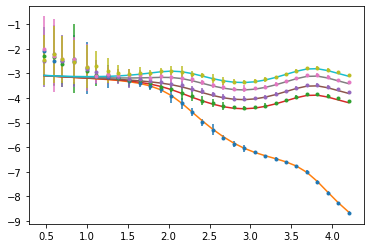

In [3]:
shift = np.array([0])

ker_var = 16.5**2 # gamma**2 - kernel variance
dist_var = 1 # sigma**2 - sample variance
dim = 100
kmax = 50
lamb = 1e-8

spectrum, degens, _ = ker_spec.get_gaussian_spectrum(ker_var, dist_var, kmax, dim)
#spectrum[0] = 0
lambda_bar = spectrum*degens
alpha = (lamb + np.sum(lambda_bar[1:]))/lambda_bar[1]
noise_var = np.array([0, 0.20928716, 0.5, 1.25, 2.5])*spectrum[1]**2*degens[1]

num_avg = 10 #100
pvals = np.logspace(0.5, 4.2, 30).astype('int')
pteach = 200

errs_tot = np.zeros((len(shift), len(pvals), len(noise_var)))

for i in range(len(shift)):
    mode_errs, errs_tot[i],_ = ker_sim.simulate_pure_gen_error(pvals, spectrum, degens, noise_var, lamb = lamb)


params = {'ker_var': ker_var, 'dist_var': dist_var, 'kmax': kmax, 'dim': dim, 
          'lamb': lamb, 'noise': noise_var, 
          'spectrum': spectrum, 'alpha': alpha, 'degens': degens,
          'num_avg': num_avg, 'pteach': pteach}


t_start = datetime.now()

all_errs = np.zeros((len(shift), len(noise_var), len(pvals)))
all_stds = np.zeros((len(shift), len(noise_var), len(pvals)))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for i in range(len(shift)):
    for n, noise in enumerate(noise_var):
        all_errs[i,n], all_stds[i,n] = ker_reg.rbf_regression_expt_gpu(pvals, pteach, dim, np.sqrt(dist_var), np.sqrt(ker_var), lamb, 
                                                       num_avg, np.sqrt(noise), errs_tot[i,:,n], num_test = 1000)
        t_end = datetime.now()
        print('\n Time Elapsed: ' + time_diff(t_start,t_end))


for i in range(len(shift)):
    for n, noise in enumerate(noise_var):
        plt.errorbar(np.log10(pvals), np.log10(all_errs[i,n]), all_stds[i,n]/all_errs[i,n], fmt = '.')
        plt.plot(np.log10(pvals), np.log10(errs_tot[i,:,n]))


if save_data:
  directory = 'GaussianRBF_examples/'
  ensure_dir(directory)
  timestamp = datetime.now().strftime("%m-%d_%H-%M")       
  filename = directory + timestamp + '_error_rbf_prl_fixed_alpha.npz'
  np.savez(filename, pvals, errs_tot, all_errs, all_stds, params)
  plt.savefig(directory + timestamp + '_final_error_curve_fix_alpha' + '.pdf', bbox_inches = 'tight')

plt.show()
